# Regularisers

Torchbearer has a number of [built-in regularisers](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#regularisers) which can be added to any image problem with a simple callback. 

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed. 

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
!pip install -q /home/matt/PycharmProjects/PyTorch-bink/
import torchbearer
print(torchbearer.__version__)

0.4.0.dev


## Data

MNIST is easy to overfit on. Lets do some regularised MNIST. 

In [2]:
import torch
from torchvision import datasets, transforms
from torchbearer.cv_utils import DatasetValidationSplitter

transform = transforms.Compose([
                        transforms.ToTensor(),
                   ])
BATCH_SIZE = 128
dataset = datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)


## Model

We take the same model as the [quickstart example](https://torchbearer.readthedocs.io/en/latest/examples/notebooks.html#general) and modify it to run on MNIST. This should run very quickly which will help us see the impact of the reguliarisers. 

In [3]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(64*2*2, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 64*2*2)
        return self.classifier(x)


model = SimpleModel()

## Set of Regularisers

torchbearer has the following built-in reguliarisers:
- **Cutout**: Randomly replaces an area of the image with a constant value
- **RandomErase**: Randomly replaces an area of the image with noise
- **MixUp**: Linearly combines two images and their labels

Here we create the callbacks for each of these in turn. 


In [4]:
from torchbearer.callbacks import Cutout, RandomErase

cutout = Cutout(n_holes=1, length=8, constant=1)
random_erase = RandomErase(n_holes=2, length=6)

## Visualising

All of the regularises that we are going to use are very visual. We would like to see how they change the image so we create a MakeGrid callback form imaging to show the input data once every epoch. 

In [5]:
import torchbearer.callbacks.imaging as imag

make_grid = imag.MakeGrid(torchbearer.INPUT, num_images=8, nrow=8)
make_grid = make_grid.on_train().to_pyplot() 

## Trial

Now lets create a number of trails and observe how each of the regularisers changes the results. 

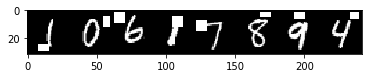

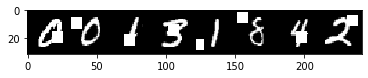

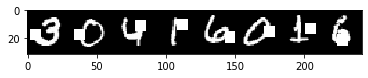

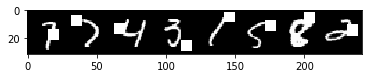

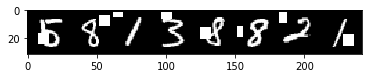

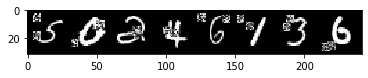

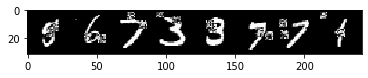

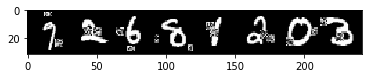

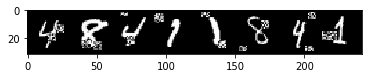

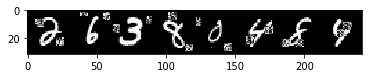

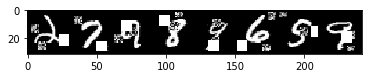

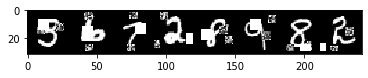

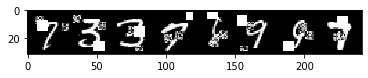

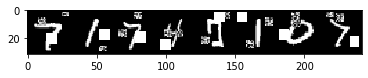

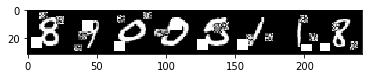

In [6]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss = nn.CrossEntropyLoss()

import torchbearer
from torchbearer import Trial

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [cutout, make_grid]
trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_cutout = trial.run(epochs=5, verbose=1)

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [random_erase, make_grid]
trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_erase = trial.run(epochs=5, verbose=1)

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [random_erase, cutout, make_grid]
trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_both = trial.run(epochs=5, verbose=1)

## Results



In [7]:


print('Final acc for cutout: {}'.format(history_cutout[-1]['val_acc']))
print('Final acc for random erase: {}'.format(history_erase[-1]['val_acc']))
print('Final acc for both: {}'.format(history_both[-1]['val_acc']))


Final acc for cutout: 0.9854999780654907
Final acc for random erase: 0.9858333468437195
Final acc for both: 0.9835000038146973
